In [6]:
!pip install albumentations==1.1.0

  Using cached albumentations-1.1.0-py3-none-any.whl (102 kB)
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.3.0
    Uninstalling albumentations-1.3.0:
      Successfully uninstalled albumentations-1.3.0


In [2]:
import os
import json
import gc
import albumentations as albu
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
from torch import Tensor


In [3]:
 pip install keras-unet-collection==0.0.7b0

Note: you may need to restart the kernel to use updated packages.


In [4]:
from keras.layers import concatenate

In [5]:
tf.config.run_functions_eagerly(True)

In [6]:

path="./train.csv"
train_df = pd.read_csv(path)
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['hasMask'] = ~ train_df['EncodedPixels'].isna()

print(train_df.shape)
train_df.head()

(22184, 5)


,Image_Label,EncodedPixels,ImageId,ClassId,hasMask
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish,True
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower,True
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel,False
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar,False
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish,True


In [7]:
mask_count_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_count_df.sort_values('hasMask', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(5546, 2)


,ImageId,hasMask
821,24dd99c.jpg,4
1885,562f80a.jpg,4
3260,944f10b.jpg,4
1872,55b539f.jpg,4
4464,cdf7242.jpg,4


In [8]:
sub_df = pd.read_csv("./sample_submission.csv")
sub_df['ImageId'] = sub_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

In [9]:
def np_resize(img, input_shape):
    """
    Reshape a numpy array, which is input_shape=(height, width), 
    as opposed to input_shape=(width, height) for cv2
    """
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

In [10]:
def visualize(image, mask, mask_prediction):
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    f, ax = plt.subplots(2, 5, figsize=(24,8))

    ax[0, 0].imshow(image.reshape(image.shape[0],image.shape[1]))
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(mask[:, :, i],vmin = 0, vmax = 1)
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
    
    ax[1, 0].imshow(image.reshape(image.shape[0],image.shape[1]))
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(mask_prediction[:, :, i],vmin = 0, vmax = 1)
        ax[1, i + 1].set_title(f'Prediction {class_dict[i]}', fontsize=fontsize)

In [11]:
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                self.min_lr + (lr - self.min_lr) * (1.0 - K.minimum(t, self.total_steps) / self.total_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f=tf.cast(y_true_f,dtype=tf.float32)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [13]:
from tensorflow.keras.utils import Sequence
from keras.utils.data_utils import Sequence



In [14]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path=r'./train_images/',
                 batch_size=32, dim=(1400, 2100), n_channels=1, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)
        
        
        ###
        self.imgs = {}
        keys = list_IDs
        
        for k in keys:
            im_name = self.df['ImageId'].iloc[k]
            img_path = f"{self.base_path}/{im_name}"
            if self.reshape is None:
                self.imgs[k] = self.__load_grayscale(img_path)
            else:
                self.imgs[k] = np_resize(self.__load_grayscale(img_path), self.reshape)
            
            self.imgs[k] = self.imgs[k].reshape((self.imgs[k].shape[0],self.imgs[k].shape[1],1))

        #
        
        self.masks = {}
        
        for k in keys:
            im_name = self.df['ImageId'].iloc[k]
            img_path = f"{self.base_path}/{im_name}"
            if self.reshape is None:
                self.imgs[k] = self.__load_grayscale(img_path)
            else:
                self.imgs[k] = np_resize(self.__load_grayscale(img_path), self.reshape)
                
            self.imgs[k] = self.imgs[k].reshape((self.imgs[k].shape[0],self.imgs[k].shape[1],1))
            
        for k in keys:
            im_name = self.df['ImageId'].iloc[k]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            self.masks[k] = masks

        #
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.imgs[ID]

            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            
            y[i, ] = self.masks[ID]

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch
    
    def getitem(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

In [15]:
'''def vanilla_unet(input_shape):

    inputs = Input(input_shape)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model'''

"def vanilla_unet(input_shape):\n\n    inputs = Input(input_shape)\n    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)\n    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)\n    p1 = MaxPooling2D((2, 2), padding='same') (c1)\n\n    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)\n    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)\n    p2 = MaxPooling2D((2, 2), padding='same') (c2)\n\n    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)\n    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)\n    p3 = MaxPooling2D((2, 2), padding='same') (c3)\n\n    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)\n    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)\n    p4 = MaxPooling2D((2, 2), padding='same') (c4)\n\n    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)\n    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)\n    p5 = MaxPooling2D((2, 2), padd

In [16]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D, Dense
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.models import Model

In [17]:
def standard_pool_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'relu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same')(input_tensor)
    x=BatchNormalization()(x)
    #x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same')(x)
    x=BatchNormalization()(x)
    #x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

In [18]:
def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'relu'

    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same')(input_tensor)
    
    #x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same')(x)
    #x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)
    
    return x

In [19]:
def Nest_Net(img_rows, img_cols, color_type=1, num_class=4, deep_supervision=False):

    nb_filter = [32,64,128,256,512]
    act = 'relu'
    global bn_axis
    bn_axis=3
    img_input = Input(shape=(img_rows, img_cols, color_type), name='main_input')

    conv1_1 = standard_pool_unit(img_input, stage='11', nb_filter=nb_filter[0])
    pool1 = MaxPooling2D((2, 2), name='pool1')(conv1_1)

    conv2_1 = standard_pool_unit(pool1, stage='21', nb_filter=nb_filter[1])
    pool2 = MaxPooling2D((2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])

    conv3_1 = standard_pool_unit(pool2, stage='31', nb_filter=nb_filter[2])
    pool3 = MaxPooling2D((2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4_1 = standard_pool_unit(pool3, stage='41', nb_filter=nb_filter[3])
    drop4 = Dropout(0.5)(conv4_1, training=True)
    pool4 = MaxPooling2D((2, 2), name='pool4')(drop4)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5_1 = standard_unit(pool4, stage='51', nb_filter=nb_filter[4])
    conv5_1 = Dropout(0.5)(conv5_1, training=True)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same')(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same')(conv1_5)

    if deep_supervision:
        model = Model(inputs=img_input, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=img_input, outputs=[nestnet_output_4])

    return model

In [19]:
'''import tensorflow as tf
from tensorflow.keras import layers

class VGGBlock(tf.keras.Model):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(VGGBlock, self).__init__()
        self.conv1 = layers.Conv2D(middle_channels, 3, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(out_channels, 3, padding='same')
        self.bn2 = layers.BatchNormalization()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = tf.nn.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = tf.nn.relu(x)
        return x

class NestedUNet(tf.keras.Model):
    def __init__(self, num_classes, input_channels=3, deep_supervision=False):
        super(NestedUNet, self).__init__()

        nb_filter = [32, 64, 128, 256, 512]

        self.deep_supervision = deep_supervision

        self.pool = layers.MaxPooling2D((2, 2))
        self.up = layers.UpSampling2D((2, 2))

        self.conv0_0 = VGGBlock(input_channels, nb_filter[0], nb_filter[0])
        self.conv1_0 = VGGBlock(nb_filter[0], nb_filter[1], nb_filter[1])
        self.conv2_0 = VGGBlock(nb_filter[1], nb_filter[2], nb_filter[2])
        self.conv3_0 = VGGBlock(nb_filter[2], nb_filter[3], nb_filter[3])
        self.conv4_0 = VGGBlock(nb_filter[3], nb_filter[4], nb_filter[4])

        self.conv0_1 = VGGBlock(nb_filter[0]+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_1 = VGGBlock(nb_filter[1]+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_1 = VGGBlock(nb_filter[2]+nb_filter[3], nb_filter[2], nb_filter[2])
        self.conv3_1 = VGGBlock(nb_filter[3]+nb_filter[4], nb_filter[3], nb_filter[3])

        self.conv0_2 = VGGBlock(nb_filter[0]*2+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_2 = VGGBlock(nb_filter[1]*2+nb_filter[2], nb_filter[1], nb_filter[1])
        self.conv2_2 = VGGBlock(nb_filter[2]*2+nb_filter[3], nb_filter[2], nb_filter[2])

        self.conv0_3 = VGGBlock(nb_filter[0]*3+nb_filter[1], nb_filter[0], nb_filter[0])
        self.conv1_3 = VGGBlock(nb_filter[1]*3+nb_filter[2], nb_filter[1], nb_filter[1])

        self.conv0_4 = VGGBlock(nb_filter[0]*4+nb_filter[1], nb_filter[0], nb_filter[0])

        if self.deep_supervision:
            self.final1 = layers.Conv2D(num_classes, 1)
            self.final2 = layers.Conv2D(num_classes, 1)
            self.final3 = layers.Conv2D(num_classes, 1)  
            self.final4 = layers.Conv2D(num_classes, 1)  

        else :
          self.final=layers.Conv2D(num_classes,1)

        

    def call(self, input):
        x0_0 = self.conv0_0(input)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x0_1 = self.conv0_1(tf.concat([x0_0, self.up(x1_0)], axis=3))

        x2_0 = self.conv2_0(self.pool(x1_0))
        x1_1 = self.conv1_1(tf.concat([x1_0, self.up(x2_0)], axis=3))
        x0_2 = self.conv0_2(tf.concat([x0_0, x0_1, self.up(x1_1)], axis=3))

        x3_0 = self.conv3_0(self.pool(x2_0))
        x2_1 = self.conv2_1(tf.concat([x2_0, self.up(x3_0)], axis=3))
        x1_2 = self.conv1_2(tf.concat([x1_0, x1_1, self.up(x2_1)], axis=3))
        x0_3 = self.conv0_3(tf.concat([x0_0, x0_1, x0_2, self.up(x1_2)], axis=3))

        x4_0 = self.conv4_0(self.pool(x3_0))
        x3_1 = self.conv3_1(tf.concat([x3_0, self.up(x4_0)], axis=3))
        x2_2 = self.conv2_2(tf.concat([x2_0, x2_1, self.up(x3_1)], axis=3))
        x1_3 = self.conv1_3(tf.concat([x1_0, x1_1, x1_2, self.up(x2_2)], axis=3))
        x0_4 = self.conv0_4(tf.concat([x0_0, x0_1, x0_2, x0_3, self.up(x1_3)], axis=3))  
        return x0_4'''




"import tensorflow as tf\nfrom tensorflow.keras import layers\n\nclass VGGBlock(tf.keras.Model):\n    def __init__(self, in_channels, middle_channels, out_channels):\n        super(VGGBlock, self).__init__()\n        self.conv1 = layers.Conv2D(middle_channels, 3, padding='same')\n        self.bn1 = layers.BatchNormalization()\n        self.conv2 = layers.Conv2D(out_channels, 3, padding='same')\n        self.bn2 = layers.BatchNormalization()\n\n    def call(self, inputs):\n        x = self.conv1(inputs)\n        x = self.bn1(x)\n        x = tf.nn.relu(x)\n\n        x = self.conv2(x)\n        x = self.bn2(x)\n        x = tf.nn.relu(x)\n        return x\n\nclass NestedUNet(tf.keras.Model):\n    def __init__(self, num_classes, input_channels=3, deep_supervision=False):\n        super(NestedUNet, self).__init__()\n\n        nb_filter = [32, 64, 128, 256, 512]\n\n        self.deep_supervision = deep_supervision\n\n        self.pool = layers.MaxPooling2D((2, 2))\n        self.up = layers.UpSa

In [24]:
%%time
BATCH_SIZE = 16
SUFFLE = True
AUGMENT = True

train_idx, val_idx = train_test_split(
    mask_count_df.index, random_state=2019, test_size=0.2
)
train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE,
    reshape=(128, 128),
    augment=AUGMENT,
    shuffle=SUFFLE,
    n_channels=1,
    n_classes=4
)
print("Train generator load")

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    reshape=(128, 128),
    augment=False,
    shuffle=SUFFLE,
    n_channels=1,
    n_classes=4,

)
print("Validation generator load")

check_generator = DataGenerator(
    #val_idx[0:10],
    val_idx,
    df=mask_count_df, 
    target_df=train_df,
    #mode='predict',
    shuffle=False,
    reshape=(128, 128),
    augment=False,
    n_channels=1,
    n_classes=4,
    batch_size=1,
)
print("Check generator load")

Train generator load
Validation generator load
Check generator load
Wall time: 6min 22s


In [26]:
model = Nest_Net(128, 128,1)
model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv11_1 (Conv2D)               (None, 128, 128, 32) 320         main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128, 128, 32) 128         conv11_1[0][0]                   
__________________________________________________________________________________________________
conv11_2 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization_16[0][0]     
____________________________________________________________________________________________

In [25]:
checkpoint = ModelCheckpoint('model_0.h5', save_best_only=True)
history0 = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    epochs=25
)

Epoch 1/25
134/277 [=============>................] - ETA: 11:35 - loss: 0.8267 - accuracy: 0.5048

KeyboardInterrupt: 

In [27]:
model.load_weights('model_0.h5')

batch_pred_masks = model.predict_generator(
    check_generator, 
    workers=1,
    verbose=1
)

C:\Users\VISHNU\anaconda3\lib\site-packages\keras\engine\training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
C:\Users\VISHNU\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:4211: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1110/1110 [==============================] - 188s 169ms/step


In [32]:
a=[]
b=[]
c=[]
d=[]

In [33]:
from sklearn.metrics import precision_recall_fscore_support

# Threshold the predicted masks
threshold = 0.5
batch_pred_masks[batch_pred_masks >= threshold] = 1
batch_pred_masks[batch_pred_masks < threshold] = 0

# Define a threshold for converting the predicted mask into a binary mask
threshold = 0.5


# Convert the predicted masks into binary masks
batch_pred_masks_binary = np.zeros_like(batch_pred_masks)
batch_pred_masks_binary[batch_pred_masks >= threshold] = 1

# Get the true masks from the check generator
batch_true_masks = np.zeros_like(batch_pred_masks_binary)
for i, (_, mask) in enumerate(check_generator):
    batch_true_masks[i] = mask
    if i == len(batch_pred_masks_binary) - 1:
        break

# Get the labels from the true and predicted masks
batch_true_labels = np.argmax(batch_true_masks, axis=-1)
batch_pred_labels = np.argmax(batch_pred_masks_binary, axis=-1)

# Compute precision, recall, and F1 score for each label
num_labels = 4
precision = np.zeros(num_labels)
recall = np.zeros(num_labels)
f1_score = np.zeros(num_labels)
accuracy=np.zeros(num_labels)
for label in range(num_labels):
    true_positives = np.sum((batch_true_labels == label) & (batch_pred_labels == label))
    
    false_positives = np.sum((batch_true_labels != label) & (batch_pred_labels == label))
    
    false_negatives = np.sum((batch_true_labels == label) & (batch_pred_labels != label))
    
    true_negatives = np.sum((batch_true_labels != label) & (batch_pred_labels != label))
    
    
    a.append(true_positives)
    b.append(false_positives)
    c.append(false_negatives)
    d.append(true_negatives)
    accuracy[label]=(true_positives+true_negatives)/(true_positives+false_negatives+false_positives+true_negatives + 1e-7)
    precision[label] = true_positives / (true_positives + false_positives + 1e-7)
    recall[label] = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score[label] = 2 * precision[label] * recall[label] / (precision[label] + recall[label] + 1e-7)
print('accuracy:',accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)
print(a)
print(b)
print(c)
print(d)

accuracy: [0.76331633 0.90631934 0.86704739 0.88813284]
Precision: [0.84413009 0.61321604 0.46501945 0.52018692]
Recall: [0.76934111 0.69724004 0.59459496 0.54232616]
F1 score: [0.80500221 0.65253426 0.52188455 0.53102584]
[8884822, 1599758, 1319628, 1151814]
[1640596, 1009042, 1518163, 1062417]
[2663790, 694657, 899745, 972026]
[4997032, 14882783, 14448704, 14999983]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Threshold the predicted masks
threshold = 0.5
batch_pred_masks[batch_pred_masks >= threshold] = 1
batch_pred_masks[batch_pred_masks < threshold] = 0

# Define a threshold for converting the predicted mask into a binary mask
threshold = 0.5


# Convert the predicted masks into binary masks
batch_pred_masks_binary = np.zeros_like(batch_pred_masks)
batch_pred_masks_binary[batch_pred_masks >= threshold] = 1

# Get the true masks from the check generator
batch_true_masks = np.zeros_like(batch_pred_masks_binary)
for i, (_, mask) in enumerate(check_generator):
    batch_true_masks[i] = mask
    if i == len(batch_pred_masks_binary) - 1:
        break

# Get the labels from the true and predicted masks
batch_true_labels = np.argmax(batch_true_masks, axis=-1)
batch_pred_labels = np.argmax(batch_pred_masks_binary, axis=-1)

# Compute precision, recall, and F1 score for each label
num_labels = 4
precision = np.zeros(num_labels)
recall = np.zeros(num_labels)
f1_score = np.zeros(num_labels)
for label in range(num_labels):
    true_positives = np.sum((batch_true_labels == label) & (batch_pred_labels == label))
    false_positives = np.sum((batch_true_labels != label) & (batch_pred_labels == label))
    false_negatives = np.sum((batch_true_labels == label) & (batch_pred_labels != label))
    precision[label] = true_positives / (true_positives + false_positives + 1e-7)
    recall[label] = true_positives / (true_positives + false_negatives + 1e-7)
    f1_score[label] = 2 * precision[label] * recall[label] / (precision[label] + recall[label] + 1e-7)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

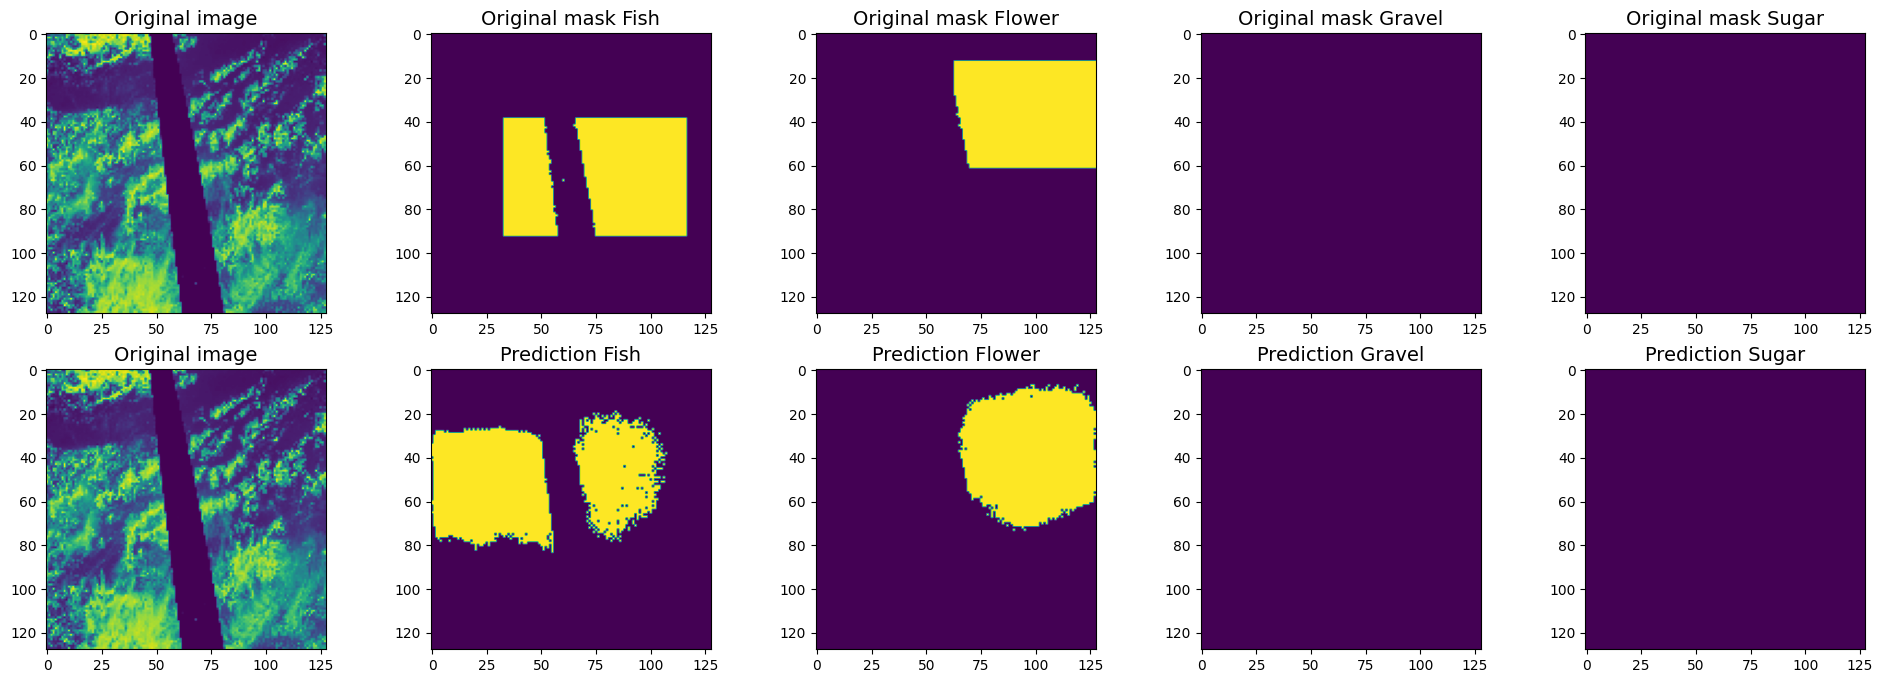

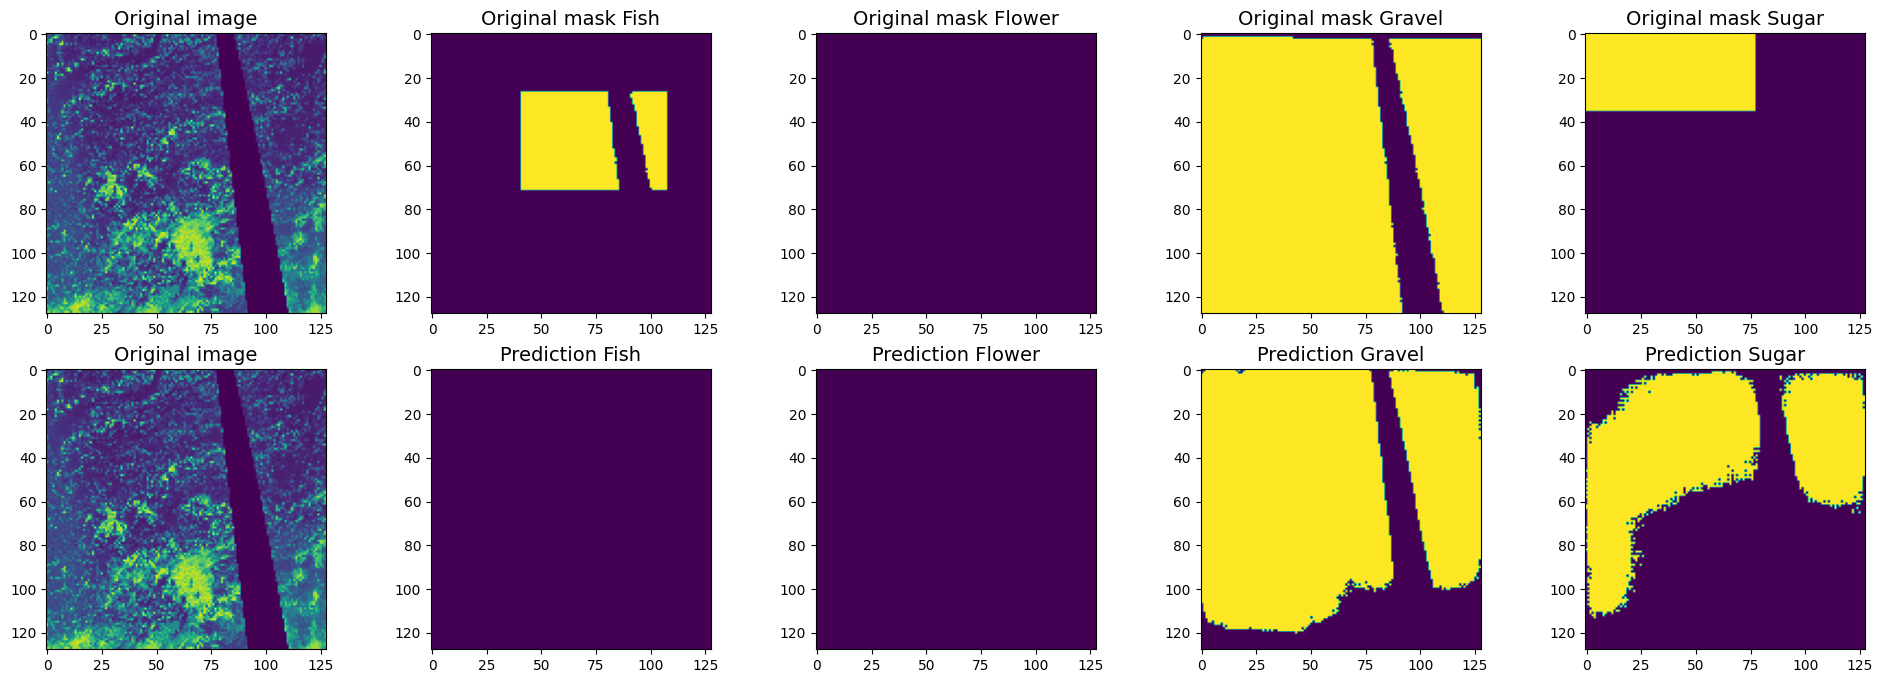

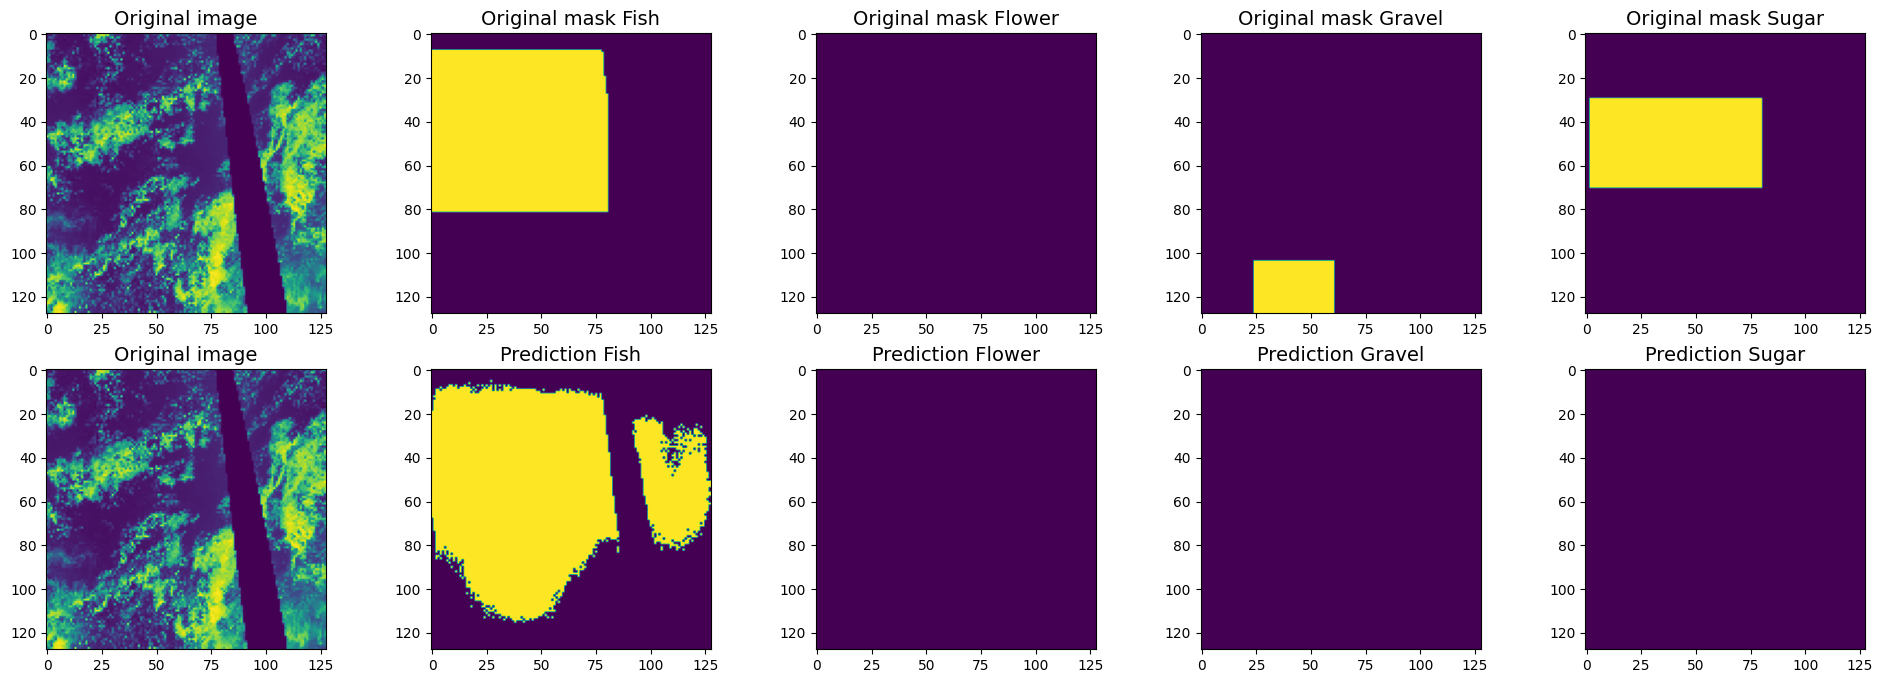

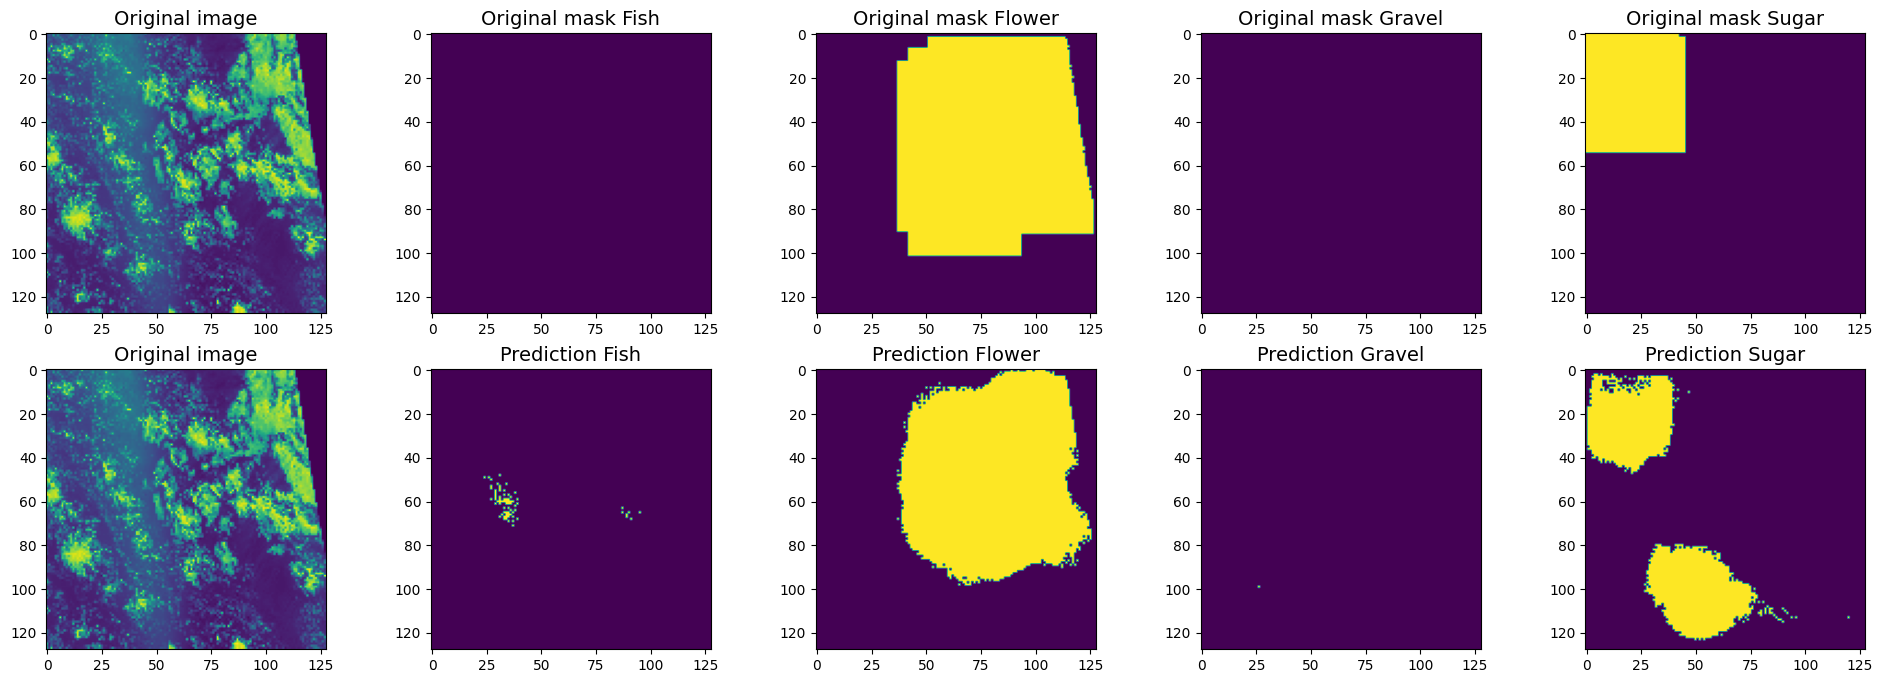

In [34]:
for i in range(4):
    visualize(check_generator.getitem(i)[0][0,:,:,:],check_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])

In [ ]:
#evaluation
evaluation = model.evaluate_generator(
    check_generator, 
    workers=1,
    verbose=1
)
evaluation0 = evaluation
print(f"Best val loss: {evaluation[0]:.3f} dice : {evaluation[1]:.3f}")

In [ ]:
dice_label_result = np.zeros((len(batch_pred_masks),4))
k = 1
n_labeles_gt = np.array([0,0,0,0])
for i in range(len(batch_pred_masks)):
    for l in range(4):
        a = batch_pred_masks[i][:,:,l]
        a[a>=0.5] = 1
        a[a<0.5] = 0
        a = a.astype(int)
        b = check_generator.getitem(i)[1][0,:,:,l]
        
        dice_label_result[i,l] = np.sum(a[b==k])*2.0 / (np.sum(a) + np.sum(b))
        
        #count labels in ground truth
        if check_generator.getitem(i)[1][0,:,:,l].max() == 1:
            n_labeles_gt[l] = n_labeles_gt[l]+1
            


In [ ]:
l0 = len(dice_label_result[dice_label_result[:,0] > 0.5])/n_labeles_gt[0]
l1 = len(dice_label_result[dice_label_result[:,1] > 0.5])/n_labeles_gt[1]
l2 = len(dice_label_result[dice_label_result[:,2] > 0.5])/n_labeles_gt[2]
l3 = len(dice_label_result[dice_label_result[:,3] > 0.5])/n_labeles_gt[3]

label_name = ("Fish","Flower","Gravel","Sugar")
y_pos = np.arange(len(label_name))
labels = [l0,l1,l2,l3]

plt.bar(y_pos, labels, align='center', alpha=0.5)
plt.xticks(y_pos, label_name)
plt.ylabel('% of hits')
plt.title('% of outputs match ground truth dice 0.5')

plt.show()

In [ ]:
#Fish Detected

In [ ]:
label_name = ("Fish","Flower","Gravel","Sugar")
for i in range (100):
    if(dice_label_result[i,0] >0.7):
        visualize(check_generator.getitem(i)[0][0,:,:,:],check_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])
        break

In [ ]:
#Fish false positive

In [ ]:
for i in range (100):
    if(dice_label_result[i,0] < 0.3):
        visualize(check_generator.getitem(i)[0][0,:,:,:],check_generator.getitem(i)[1][0,:,:,:],batch_pred_masks[i])
        break